In [1]:
import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt

from xml.dom import minidom
import os
from datetime import date

c:\Users\santh\Desktop\Python Projects\Masters Thesis\Multi_particleTracking\GraphTrack\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\Users\santh\Desktop\Python Projects\Masters Thesis\Multi_particleTracking\GraphTrack\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


In [62]:

def ProcessDataset(scale_traj, shift_traj, seq_length = 10, **kwargs):
    def inner(data):
        trajectories = []
        trajs = np.array(data)[:, 2:]
        
        # scale, shift, strip
        for traj in trajs:
            traj[:seq_length] = (
                scale_traj * (traj[:seq_length])
                + np.random.rand(1) * shift_traj
            )

            traj[seq_length:] = (
                scale_traj * (traj[seq_length:])
                + np.random.rand(1) * shift_traj
            )

            trajectories.append(
                np.transpose([traj[:seq_length], traj[seq_length:]])
            )
        return trajectories
    return inner

def to_xml(**kwargs): # , mean_radii, std_radius
    def inner(data):

        root = minidom.Document()
        xml = root.createElement("root")
        root.appendChild(xml)

        data, intensities = dataset.update().resolve()  
        
        description = root.createElement("GlobalHeterogenousInfo")
        description.attributes["scenario"] = "Heterogeneous alpha"
        #description.attributes["global_prop"] = str(data[0].get_property("percentage_alpha"))
        description.attributes["total_particles"] = str(np.sum(data[0].get_property("N")))
        description.attributes["sequence_length"] = str(data[0].get_property("seq_length"))
        description.attributes["model"] = str(data[0].get_property("model"))
        description.attributes["generationDateTime"] = str(date.today())
        xml.appendChild(description)
        
    
        #alphas = data[0].get_property("alpha")
        for idx, traj in enumerate(data): #, mean_radius # , mean_radii
            particle = root.createElement("particle")
            description.appendChild(particle)
            
            traj = np.array(traj)
            #intensities = np.random.normal(len(traj))
            #radii = np.random.normal(mean_radius, std_radius, len(traj))
            for frame, coord in enumerate(traj): # , radius # , radii
                point = root.createElement("detection")
                point.attributes["frame"] = str(frame)
                point.attributes["x"] = str(coord[0])
                point.attributes["y"] = str(coord[1])
                point.attributes["intensity"] = str(intensities[idx, frame])
                
                point.attributes["solution"] = str(0)#str(alphas[idx])
                
                particle.appendChild(point)
    
        return root
    return inner


import numpy as np

def generate_fix_sum_random_vec(limit, num_elem, tries=10):
    v = np.random.randint(0, limit, num_elem)
    s = sum(v)
    if (np.sum(np.round(v/s*limit)) == limit):
        return np.round(v / s * limit)
    elif (np.sum(np.floor(v/s*limit)) == limit):
        return np.floor(v / s * limit)
    elif (np.sum(np.ceil(v/s*limit)) == limit):
        return np.ceil(v / s * limit)
    else:
        return generate_fix_sum_random_vec(limit, num_elem, tries-1)

In [76]:

class Sim(dt.Feature):

    def get(self, image, N, seq_length, **kwargs):

        box_size = [100, 530]
        radius = 3 + np.random.rand(N)*1

        intensities = np.zeros((N, seq_length))
        a = 60+np.random.rand(N)*35
        for i in range(len(intensities)):
            b = np.random.normal(loc = a[i], scale = 2, size = seq_length)

            intensities[i,:] = b 
                
        x_0 = 0 + np.random.rand(N)*box_size[1]
        y_0 = 0 + np.random.rand(N)*box_size[0]

        v = 4+np.random.rand(N)*2
        for i in range(len(v)):
            if np.random.rand()>.2:
                v[i] /= 6
                
        #T = 5 #sec
        del_t = 1 # sec

        phi = np.random.rand(N)*2*np.pi

        D_t = np.ones(N)*.2
        D_r = np.ones(N)*.5


        x = np.zeros((seq_length+1, N))
        y = np.zeros((seq_length+1, N))

        x[0] = x_0
        y[0] = y_0

                
        for i in range(seq_length):
            W_x = np.random.normal(loc = 0, scale = 1, size = N)
            W_y = np.random.normal(loc = 0, scale = 1, size = N)
            W_phi = np.random.normal(loc = 0, scale = 1, size = N)

            #Updating x & y velocities
            v_x = v*np.transpose(np.cos(phi)) + np.sqrt(2*D_t)*W_x

            v_y = v*np.transpose(np.sin(phi)) + np.sqrt(2*D_t)*W_y

            #Updating rotational vel.
            v_phi = np.sqrt(2*D_r)*W_phi
            
            #Updating the x and y coordinates

            x[i+1] = x[i] +v_x*del_t
            y[i+1] = y[i] + v_y*del_t

            #Updating angle
            phi = phi + v_phi*del_t
            
            for _ in range(25):

                for j in range(N):
                    for k in range(N):
                        if j!=k:
                            r_jk = np.sqrt(np.square(x[i+1,j]-x[i+1,k])+ np.square(y[i+1,j]-y[i+1,k]) )
                            if r_jk < (radius[j]+radius[k]):
                                dist_2b_moved = radius[j]+radius[k] - r_jk
                                theta = np.arctan2([y[i+1,k], y[i+1,j]], [x[i+1,k], x[i+1,j]])[0]
                                x[i+1, j] -= dist_2b_moved/2*np.cos(theta)
                                y[i+1, j] -= dist_2b_moved/2*np.sin(theta)
                                            
                                x[i+1, k] += dist_2b_moved/2*np.cos(theta)
                                y[i+1, k] += dist_2b_moved/2*np.sin(theta)
                            
            for p in range(N):
                if x[i+1,p] >= box_size[1] and y[i+1,p] >= box_size[0]:
                    x[i+1,p] = box_size[1]
                    y[i+1,p] = box_size[0]
                    phi[p] = -3*np.pi/4
                    continue

                if x[i+1,p] >= box_size[1] and y[i+1,p] <= 0:
                    x[i+1,p] = box_size[1]
                    y[i+1,p] = 0
                    phi[p] = 3*np.pi/4
                    continue

                if x[i+1,p] <= 0 and y[i+1,p] >= box_size[0]:
                    x[i+1,p] = 0
                    y[i+1,p] = box_size[0]
                    phi[p] = -np.pi/4
                    continue

                if x[i+1,p] <= 0 and y[i+1,p] <= 0:
                    x[i+1,p] = 0
                    y[i+1,p] = 0
                    phi[p] = np.pi/4
                    continue

                if x[i+1,p] > box_size[1]: 
                    x[i+1,p] = box_size[1]
                    phi[p] = np.pi-phi[p]

                if x[i+1,p] <= 0:
                    x[i+1,p] = 0
                    phi[p] = np.pi-phi[p]
                
                if y[i+1,p] > box_size[0]: 
                    y[i+1,p] = box_size[0]
                    phi[p] = -phi[p]

                if y[i+1,p] < 0:
                    y[i+1,p] = 0
                    phi[p] = -phi[p]
                
        return np.transpose(np.array([x[1:,:], y[1:,:]])), intensities




In [77]:

sim = Sim(
    N=lambda: 60 + np.random.randint(10) ,
    seq_length=lambda: 30 + np.random.randint(10) ,
    
)

starting_value = dt.Value(lambda: np.ones((10, 10)))

dataset = starting_value >> sim

In [68]:
data, intensities = dataset.update().resolve()

In [78]:
xml_loader = dataset >> dt.Lambda(
     to_xml
     
     )
        
     
     

In [79]:
mode = ["training","testing"]
os.makedirs("xml-generators/xml_data/mixed_alpha_nodes/"+mode[0], exist_ok=True)
os.makedirs("xml-generators/xml_data/mixed_alpha_nodes/"+mode[1], exist_ok=True)

In [80]:
_SAMPLES_ = [200, 5] #[Training, Testing]

for i in range(len(_SAMPLES_)):
    for sample in range(_SAMPLES_[i]):
        xml = xml_loader.update().resolve()
        with open("xml-generators/xml_data/mixed_alpha_nodes/"+mode[i]+"/sample_"+str(sample+1)+".xml", "w") as f:
            f.write(xml.toprettyxml(indent ="\t"))

In [45]:
import untangle

path  = "./xml-generators_sim/xml_data/mixed_alpha_nodes/training/sample_2.xml"
xml = untangle.parse(path)

In [46]:
particles = xml.root.GlobalHeterogenousInfo.particle

detection_list = []
for p in range(len(particles)):
    detections = particles[p].detection
    for d in range(len(detections)):
        detection_att = {
            "frame": int(detections[d]["frame"]),
            "centroid_x": float(detections[d]["x"]),
            "centroid_y": float(detections[d]["y"]),
            #"intensity": float(detections[d]["intensity"]),
            "label": int(p + 1),
            "solution": float(detections[d]["solution"])
            }
        detection_list.append(detection_att)

In [47]:
import pandas as pd
df = (
    pd.DataFrame.from_dict(detection_list)
    .sort_values(by=["frame"])
    .reset_index(drop=True)
)

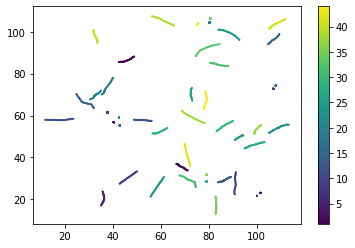

In [49]:
x = df["centroid_x"].values
y = df["centroid_y"].values
z = df["label"].values

import matplotlib.pyplot as plt

plt.scatter(x, y, c=z, s=1)
plt.colorbar()